In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../.."))

In [12]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np

from constants import IMP_ITEM_IDS
from helper import normalize_value

# Database
from db import PostgresDB
from schemas import Proband
from cohorts import Cohort

# Clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
import umap.umap_ as umap


# Plotting matrix
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from plotting import plot_endpoints_for_clusters
sns.color_palette()



[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [13]:
load_dotenv()

True

In [14]:
# CLUSTERING
N_CLUSTERS = 20
N_COMPONENTS = 2

In [15]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD")
)

Connected to database


In [16]:
PICKLE_PATH = "../scripts/TR1/icd.pickle"

In [17]:
sim_df = pd.read_pickle(PICKLE_PATH)
# distance matrix for clustering
dist_df = np.subtract(1, sim_df)

In [18]:
# Clustering
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(dist_df)
# kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(dist_df)
affinity_cluster = AffinityPropagation().fit(dist_df)

clusters = [
    spectral_cluster,
    affinity_cluster,
]

In [19]:
def plot_cluster(df, cluster, pos, method):
    sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=cluster.labels_, cmap="").set_title(
        f"{cluster.__class__.__name__}, {method.upper()}"
    )

In [20]:
tsne = TSNE(n_components=N_COMPONENTS)
tsne_pos = tsne.fit_transform(dist_df)

reducer = umap.UMAP()
umap_pos = reducer.fit_transform(dist_df)

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


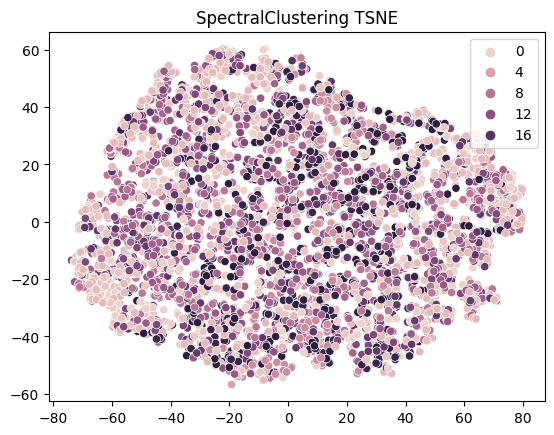

In [21]:
sns.scatterplot(
    x=tsne_pos[:, 0], y=tsne_pos[:, 1], hue=spectral_cluster.labels_, cmap=""
).set_title(f"{spectral_cluster.__class__.__name__} TSNE")
plt.show()


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


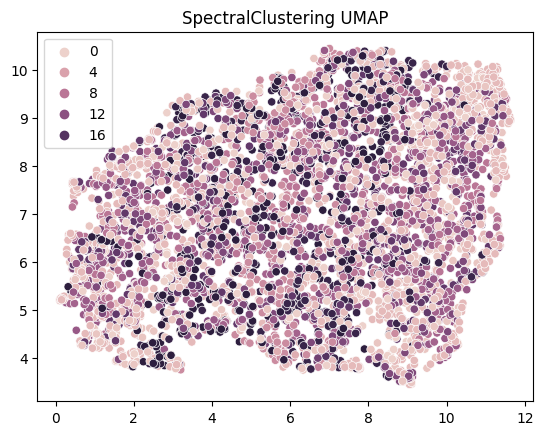

In [22]:
sns.scatterplot(
    x=umap_pos[:, 0], y=umap_pos[:, 1], hue=spectral_cluster.labels_, cmap=""
).set_title(f"{spectral_cluster.__class__.__name__} UMAP")
plt.show()


In [23]:
participants = [Proband(hadm_id=i) for i in dist_df.columns]
for p in participants:
    los_icu, los_hosp = db.get_endpoints_for_hadm_id(p.hadm_id)
    p.los_icu = los_icu
    p.los_hosp = los_hosp

In [24]:
hadm_ids = [p.hadm_id for p in participants]

In [25]:
def plot_item_tsne():
    for k, v in IMP_ITEM_IDS.items():
        item_id = v
        le = db.get_labevent_by_id_for_hadm_ids(hadm_ids=hadm_ids, item_id=item_id)
        id_val_dic = {}
        for i in le:
            id_val_dic[i.hadm_id] = {
                "val": i.valuenum,
                "mean": i.id_mean,
                "std": i.id_std_dev,
            }
        values = []
        for id in hadm_ids:
            if id in id_val_dic:
                value = id_val_dic[id]["val"]
                if value is None:
                    values.append(0)
                    continue
                mean = id_val_dic[id]["mean"]
                std = id_val_dic[id]["std"]
                if std == 0:
                    values.append(0)
                    continue
                values.append(normalize_value(value, mean, std))
            else:
                values.append(0)
        sns.scatterplot(
            x=tsne_pos[:, 0],
            y=tsne_pos[:, 1],
            hue=values,
            legend=False,
            cmap="RdYlBu_r",
        ).set_title(f"{k} TSNE")
        plt.show()
